# Multi Layered Perceptron (MLP) - A quick (re-)introduction usng PyTorch

In this notebook, we will train a simple MLP on the EMNIST data set using PyTorch library

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init as weight_init
import matplotlib.pyplot as plt
import numpy as np
import random

from loadFashionMNIST import FashionMNIST

### Selecting gpu device if cuda is available

In [2]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")

Using PyTorch version: 0.4.1 CUDA: True


### Define data set

In [3]:
train_dataset = FashionMNIST(split='train')
test_dataset = FashionMNIST(split='test')

### Visualize data set

60000
torch.Size([1, 28, 28])
tensor(4)


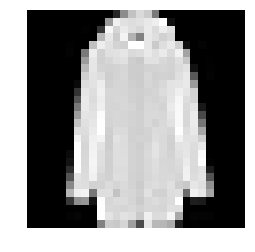

In [4]:
print(len(train_dataset))
print(train_dataset[0][0].size())
plt.figure()
plt.axis('off')
plt.imshow(train_dataset[0][0].squeeze().numpy(),cmap='gray')
print(train_dataset[0][1])

### Define a data loader

In [5]:
batch_size = 10
#loading the train dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# loading the test dataset

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

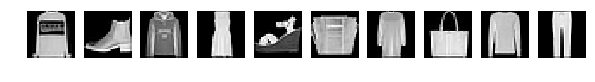

In [6]:
#Plotting 10 samples
for (X_train, y_train) in train_loader:
    pltsize=1
    plt.figure(figsize=(10*pltsize, pltsize))
    
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.axis('off')
        plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    break

### Define a simple MLP

Let's define the network as a Python class. This Python class inherits functions from _nn.module_.

There are three convenient functions that are defined in this class:

- ### **\__init__()**:
In this function, we shall declare all the layers of our neural network, including the number of neurons, non-linear activations, etc.

- ### **forward()**:
This is the function that is used to compute forward pass of the network. Here, we shall connect the different layers we had defined in \__init__, according to the network architecture we want to make. In this case, $x -> fc1 -> relu -> fc2 -> out$.

"forward" can be called by calling the object of this class directly. For example:

```
net = Network()
out = net(x)
```

- ### **backward()**:
This function is used to compute gradients across the entire network, and is called from the loss function at the end of the network.

```
loss.backward()
```

We have to write the **__init__()** and **forward()** methods, and PyTorch will automatically generate a **backward()** method for computing the gradients for the backward pass.

In [7]:
# Hyper Parameters 
input_size = 784
hidden1_size = 512
hidden2_size = 256
num_classes = 10
num_epochs = 3
learning_rate = 0.1

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        
        #Weight Initialization
        for m in self.modules():
          if isinstance(m,nn.Linear):
            weight_init.xavier_normal_(m.weight)


    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=1)
        return out

### Creating MLP object and transfering it to GPU

In [9]:
net = Net(input_size, hidden1_size, hidden2_size, num_classes)
print(net)
net = net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Define loss and optimizer

In [10]:
# Cross entropy loss for optimizer
criterion = nn.CrossEntropyLoss()

In [11]:
# SGD for Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  

### Train the MLP

In [12]:
# In each epoch
for epoch in range(num_epochs):
    correct = 0
    total = 0
    
    # For each batch of images in train set
    for i, (images, labels) in enumerate(train_loader):
        
        
        images = images.view(-1, 28*28)
        labels = labels
        
        images, labels = images.to(device), labels.to(device)
        
        # Initialize gradients to 0
        optimizer.zero_grad()
        
        # Forward pass (this calls the "forward" function within Net)
        outputs = net(images)
        
        # Find the loss
        loss = criterion(outputs, labels)
        
        # Find the gradients of all weights using the loss
        loss.backward()
        
        # Update the weights using the optimizer
        # For e.g.: w = w - (delta_w)*lr
        optimizer.step()
        
        # Find the output by doing a forward pass through the network
        outputs = net(images)

        # Find the class of each sample by taking a max across the probabilities of each class
        _, predicted = torch.max(outputs.data, 1)

        # Increment 'total', and 'correct' according to whether the prediction was correct or not
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        if (i+1) % 1000 == 0:
            print ('Epoch [%d/%d], Step [%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, loss.item()))
            
    print('Training accuracy for epoch {} is {}%'.format(epoch+1, (100 * correct / total)))

Epoch [1/3], Step [1000], Loss: 1.8266
Epoch [1/3], Step [2000], Loss: 1.6161
Epoch [1/3], Step [3000], Loss: 1.6708
Epoch [1/3], Step [4000], Loss: 2.1191
Epoch [1/3], Step [5000], Loss: 1.7559
Epoch [1/3], Step [6000], Loss: 1.4616
Training accuracy for epoch 1 is 77%
Epoch [2/3], Step [1000], Loss: 1.8584
Epoch [2/3], Step [2000], Loss: 1.6608
Epoch [2/3], Step [3000], Loss: 1.7581
Epoch [2/3], Step [4000], Loss: 1.5613
Epoch [2/3], Step [5000], Loss: 1.8682
Epoch [2/3], Step [6000], Loss: 1.5030
Training accuracy for epoch 2 is 80%
Epoch [3/3], Step [1000], Loss: 1.4785
Epoch [3/3], Step [2000], Loss: 1.6504
Epoch [3/3], Step [3000], Loss: 1.6599
Epoch [3/3], Step [4000], Loss: 1.4612
Epoch [3/3], Step [5000], Loss: 1.5614
Epoch [3/3], Step [6000], Loss: 1.6615
Training accuracy for epoch 3 is 80%


### Evaluate the MLP

In [13]:
correct = 0
total = 0

# For each batch of images in test set
with torch.set_grad_enabled(False):
    for images, labels in test_loader:

      # Get the images
      images = images.view(-1, 28*28)

      images = images.to(device)

      # Find the output by doing a forward pass through the network
      outputs = net(images)

      # Find the class of each sample by taking a max across the probabilities of each class
      _, predicted = torch.max(outputs.data, 1)

      # Increment 'total', and 'correct' according to whether the prediction was correct or not
      total += labels.size(0)
      correct += (predicted.cpu() == labels).sum()

print('Test accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Test accuracy of the network on the 10000 test images: 78 %
